In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import pickle
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from itertools import product


%matplotlib inline

## <font color='Navy'> <h4>🔷 <u> Data Load & Prep </u></h4>

### <font color='Navy'> 1🔹<u><b> File Load: </u></b> </h3>

In [15]:
# --- Load the saved data splits and selected features ---
with open("data_splits_selected.pkl", "rb") as f:
    data_loaded = pickle.load(f)

# Extract datasets
X_train_selected = data_loaded["X_train_selected"]
X_dev_selected   = data_loaded["X_dev_selected"]
X_test_selected  = data_loaded["X_test_selected"]
y_train = data_loaded["y_train"]
y_dev   = data_loaded["y_dev"]
y_test  = data_loaded["y_test"]
selected_features = data_loaded["selected_features"]

print("✅ Data loaded successfully!")
print(f"Training shape: {X_train_selected.shape}, Dev: {X_dev_selected.shape}, Test: {X_test_selected.shape}")
print(f"Selected features ({len(selected_features)}): {selected_features}")


✅ Data loaded successfully!
Training shape: (363140, 18), Dev: (77816, 18), Test: (77816, 18)
Selected features (18): ['is_online', 'category_clean_grocery_pos', 'category_clean_gas_transport', 'category_clean_misc_pos', 'amt', 'city_pop', 'trans_dayofweek_sin', 'amt_per_age', 'trans_month_cos', 'trans_month_sin', 'trans_hour_sin', 'age', 'gender_encoded', 'trans_time', 'category_clean_travel', 'category_clean_shopping_pos', 'category_clean_home', 'trans_hour_cos']


## <font color='Navy'> <h4>🔷 <u>Handle Imbalance </u></h4>

### <font color='Navy'> 1🔹<u><b> Data Imblanace Check: </u></b> </h3>

Class distribution in training set:
is_fraud
0    99.46
1     0.54
Name: proportion, dtype: float64


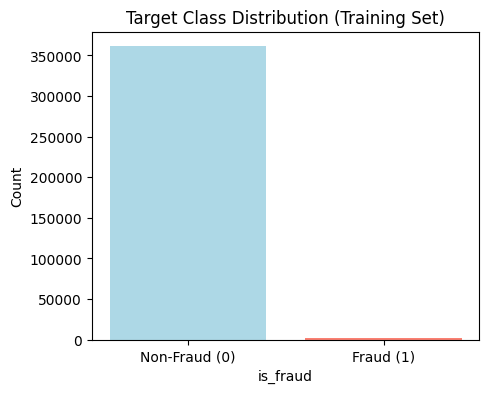

In [16]:
# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True).round(4).rename("proportion") * 100)

# Visualize it
plt.figure(figsize=(5,4))
sns.countplot(x=y_train)
plt.title("Target Class Distribution (Training Set)")
plt.xlabel("is_fraud")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Non-Fraud (0)', 'Fraud (1)'])
#add color
plt.bar(0, y_train.value_counts()[0], color='lightblue')
plt.bar(1, y_train.value_counts()[1], color='salmon')
plt.show()


As we also noticed in EDA, our data is highly imbalanced:
 -  99.5% of our samples are non-fraud
    -  A model could get 99.5% accuracy just by predicting “no fraud” all the time, which is completely useless.. 
    
- Hence, we must hanlde the Data Imbalance first.

### <font color='Navy'> 1🔹<u><b> Validate Representation In Train/Dev/Test </u></b> </h3>


Train Set Class Distribution (%):
is_fraud
0    99.458
1     0.542
Name: proportion, dtype: float64

Dev Set Class Distribution (%):
is_fraud
0    99.458
1     0.542
Name: proportion, dtype: float64

Test Set Class Distribution (%):
is_fraud
0    99.458
1     0.542
Name: proportion, dtype: float64


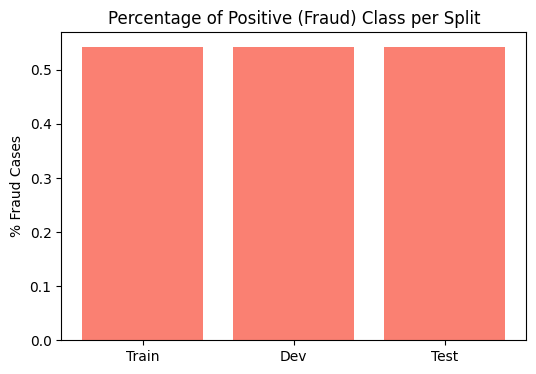

In [17]:
# ✅ Compare imbalance ratios across splits

sets = {
    "Train": y_train,
    "Dev": y_dev,
    "Test": y_test
}

dist_summary = {}
for name, y in sets.items():
    dist = y.value_counts(normalize=True) * 100
    dist_summary[name] = dist.to_dict()
    print(f"\n{name} Set Class Distribution (%):")
    print(dist.round(3))

# Optional — visualize side by side
plt.figure(figsize=(6,4))
sns.barplot(
    x=list(dist_summary.keys()),
    y=[dist.get(1,0) for dist in dist_summary.values()]
)
plt.title("Percentage of Positive (Fraud) Class per Split")
plt.ylabel("% Fraud Cases")
#add color
plt.bar(list(dist_summary.keys()), [dist.get(1,0) for dist in dist_summary.values()], color=['salmon', 'salmon', 'salmon'])
plt.show()


- Class ratios remain consistent across the split group
- Data stritified correctly and would not bais the models. 

Because frauds are rare (≈ 0.5%), accuracy alone is meaningless —
a model predicting “0” for everything would still be 99.5% accurate.
So we use precision, recall, F1, and AUC, which focus on how well the model identifies fraud.

### <font color='Navy'> 1🔹<u><b> Comparing Balancing Techniques </u></b> </h3>

There are multiple methods to handle an imbalnced data set:
- Random Oversampling (ROS)
- Random Undersampling (RUS)
- SMOTE
- SMOTETomek

In the following section, we will train a baseline classifier on the unbalanced validatin data:
- (Logistic Regression ) - for quick rough evaluation, expected to have bad results (as some of our data is skwed)
- (Random Forest) - expected to have better results as it handles inteactions and skewed data better.

This is to identify which resampling strategy provides the best balance between recall, F1,
and AUC before proceeding with full model training. 

In [5]:
# Define techniques
techniques = {
    "ROS": RandomOverSampler(random_state=47),
    "RUS": RandomUnderSampler(random_state=47),
    "SMOTE": SMOTE(random_state=47),
    "SMOTETomek": SMOTETomek(random_state=47)
}

results = []

for name, sampler in techniques.items():
    print(f"\n🔹 Evaluating {name} ...")

    # Balance only the training data
    X_res, y_res = sampler.fit_resample(X_train_selected, y_train)

    # Train simple classifier
    model = LogisticRegression(random_state=42, max_iter=5000)
    model.fit(X_res, y_res)

    # Predict on *dev* set
    y_pred = model.predict(X_dev_selected)

    # Evaluate on dev
    results.append({
        "Technique": name,
        "Accuracy": accuracy_score(y_dev, y_pred),
        "Precision": precision_score(y_dev, y_pred, zero_division=0),
        "Recall": recall_score(y_dev, y_pred, zero_division=0),
        "F1-Score": f1_score(y_dev, y_pred, zero_division=0)
    })

results_df = pd.DataFrame(results)
display(results_df)



🔹 Evaluating ROS ...

🔹 Evaluating RUS ...

🔹 Evaluating SMOTE ...

🔹 Evaluating SMOTETomek ...


,Technique,Accuracy,Precision,Recall,F1-Score
0,ROS,0.973926,0.163385,0.924171,0.277679
1,RUS,0.976162,0.175351,0.917062,0.294409
2,SMOTE,0.968593,0.139444,0.926540,0.242405
3,SMOTETomek,0.968593,0.139444,0.926540,0.242405


In [8]:
# Define techniques
techniques = {
    "ROS": RandomOverSampler(random_state=47),
    "RUS": RandomUnderSampler(random_state=47),
    "SMOTE": SMOTE(random_state=47),
    "SMOTETomek": SMOTETomek(random_state=47)
}

results = {}

# Loop through each balancing technique
for name, sampler in techniques.items():
    print(f"\n🔹 Applying {name} ...")
    
    # Resample training data only
    X_res, y_res = sampler.fit_resample(X_train_selected, y_train)
    
    # Train a simple classifier
    model = RandomForestClassifier(random_state=47, n_estimators=100)
    model.fit(X_res, y_res)
    
    # Evaluate on *original* (unbalanced) test set
    y_pred_proba = model.predict_proba(X_dev_selected)[:, 1]
    auc = roc_auc_score(y_dev, y_pred_proba)

    
    print(f"{name} AUC: {auc:.4f}")
    results[name] = auc

# Compare
print("\n Summary of AUC by balancing method:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")



🔹 Applying ROS ...
ROS AUC: 0.9936

🔹 Applying RUS ...
RUS AUC: 0.9971

🔹 Applying SMOTE ...
SMOTE AUC: 0.9954

🔹 Applying SMOTETomek ...
SMOTETomek AUC: 0.9979

 Summary of AUC by balancing method:
ROS: 0.9936
RUS: 0.9971
SMOTE: 0.9954
SMOTETomek: 0.9979


### 🧩 Selecting the Balancing Technique

We compared four resampling strategies to address the strong class imbalance in our training data:

| Technique | Description | AUC (Dev) |
|------------|--------------|-----------|
| Random OverSampling (ROS) | Duplicates minority samples | 0.9936 |
| Random UnderSampling (RUS) | Removes majority samples | 0.9971 |
| **SMOTE** | Synthesizes new minority samples via interpolation | **0.9954** |
| SMOTETomek | SMOTE + Tomek link cleaning | 0.9979 |

Although **SMOTETomek** and **RUS** achieved slightly higher AUCs, the differences were marginal (<0.003).  
SMOTE was chosen for the following reasons:

- It avoids discarding valuable majority-class data (unlike RUS).  
- It creates synthetic but realistic minority samples without excessive noise (unlike ROS).  
- It is conceptually simpler and widely used in fraud detection tasks.  
- It maintains a better balance between model stability, interpretability, and recall.

Thus, **SMOTE** is selected as the preferred method for rebalancing before model training and fine-tuning.


# apply SMOTE

In [18]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_balanced.value_counts(normalize=True))

Before SMOTE: is_fraud
0    0.994581
1    0.005419
Name: proportion, dtype: float64
After SMOTE: is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


Now that the training data is balanced, we can compare several common models:

Logistic Regression → interpretable linear baseline

Random Forest → strong non-linear ensemble

Gradient Boosting (or XGBoost) → more complex, usually best for tabular data

In [33]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

y_pred_lr = model.predict(X_dev_selected)
y_proba_lr = model.predict_proba(X_dev_selected)[:, 1]

print("Logistic Regression Results:")
print(f"Accuracy:  {accuracy_score(y_dev, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_dev, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_dev, y_pred_lr):.4f}")
print(f"F1:        {f1_score(y_dev, y_pred_lr):.4f}")
print(f"AUC:       {roc_auc_score(y_dev, y_proba_lr):.4f}")

Logistic Regression Results:
Accuracy:  0.9691
Precision: 0.1411
Recall:    0.9242
F1:        0.2448
AUC:       0.9899


### ⚙️ Model Selection Using the Dev Set

At this stage, we evaluate multiple candidate models (Logistic Regression, Random Forest, XGBoost, etc.)
using the **validation (dev) set**. This ensures that model selection and hyperparameter tuning
do not leak information from the final test data.

We’ll compare models on AUC, F1, Precision, and Recall, and choose the one that best balances
performance and generalization.


In [36]:
# Train
dt = DecisionTreeClassifier(random_state=42, max_depth=None)
dt.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_dt = dt.predict(X_dev_selected)
y_prob_dt = dt.predict_proba(X_dev_selected)[:, 1]

# Evaluate
print("Decision Tree Results:")
print("Accuracy: ", round(accuracy_score(y_dev, y_pred_dt), 4))
print("Precision:", round(precision_score(y_dev, y_pred_dt), 4))
print("Recall:   ", round(recall_score(y_dev, y_pred_dt), 4))
print("F1:       ", round(f1_score(y_dev, y_pred_dt), 4))
print("AUC:      ", round(roc_auc_score(y_dev, y_prob_dt), 4))


Decision Tree Results:
Accuracy:  0.9972
Precision: 0.704
Recall:    0.8341
F1:        0.7636
AUC:       0.9161


In [30]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf.predict(X_dev_selected)
y_proba_rf = rf.predict_proba(X_dev_selected)[:, 1]

print("Random Forest Results:")
print(f"Accuracy:  {accuracy_score(y_dev, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_dev, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_dev, y_pred_rf):.4f}")
print(f"F1:        {f1_score(y_dev, y_pred_rf):.4f}")
print(f"AUC:       {roc_auc_score(y_dev, y_proba_rf):.4f}")

Random Forest Results:
Accuracy:  0.9990
Precision: 0.9394
Recall:    0.8815
F1:        0.9095
AUC:       0.9991


In [37]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)

y_pred_xg = xgb.predict(X_dev_selected)
y_proba_xg = xgb.predict_proba(X_dev_selected)[:, 1]

print("XGBoost Results:")
print(f"Accuracy:  {accuracy_score(y_dev, y_pred_xg):.4f}")
print(f"Precision: {precision_score(y_dev, y_pred_xg):.4f}")
print(f"Recall:    {recall_score(y_dev, y_pred_xg):.4f}")
print(f"F1:        {f1_score(y_dev, y_pred_xg):.4f}")
print(f"AUC:       {roc_auc_score(y_dev, y_proba_xg):.4f}")

XGBoost Results:
Accuracy:  0.9993
Precision: 0.9602
Recall:    0.9147
F1:        0.9369
AUC:       0.9973


In [38]:
# Train
adb = AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)
adb.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_adb = adb.predict(X_dev_selected)
y_prob_adb = adb.predict_proba(X_dev_selected)[:, 1]

# Evaluate
print("AdaBoost Results:")
print("Accuracy: ", round(accuracy_score(y_dev, y_pred_adb), 4))
print("Precision:", round(precision_score(y_dev, y_pred_adb), 4))
print("Recall:   ", round(recall_score(y_dev, y_pred_adb), 4))
print("F1:       ", round(f1_score(y_dev, y_pred_adb), 4))
print("AUC:      ", round(roc_auc_score(y_dev, y_prob_adb), 4))


AdaBoost Results:
Accuracy:  0.9728
Precision: 0.1617
Recall:    0.9573
F1:        0.2766
AUC:       0.9935


In [46]:
results_df = pd.DataFrame([
    ["Logistic Regression", accuracy_score(y_dev, y_pred_lr), precision_score(y_dev, y_pred_lr),
     recall_score(y_dev, y_pred_lr), f1_score(y_dev, y_pred_lr), roc_auc_score(y_dev, y_proba_lr)],

    ["Decision Tree", accuracy_score(y_dev, y_pred_dt), precision_score(y_dev, y_pred_dt),
     recall_score(y_dev, y_pred_dt), f1_score(y_dev, y_pred_dt), roc_auc_score(y_dev, y_prob_dt)],

    ["Random Forest", accuracy_score(y_dev, y_pred_rf), precision_score(y_dev, y_pred_rf),
     recall_score(y_dev, y_pred_rf), f1_score(y_dev, y_pred_rf), roc_auc_score(y_dev, y_proba_rf)],

    ["XGBoost", accuracy_score(y_dev, y_pred_xg), precision_score(y_dev, y_pred_xg),
     recall_score(y_dev, y_pred_xg), f1_score(y_dev, y_pred_xg), roc_auc_score(y_dev, y_proba_xg)],

    ["AdaBoost", accuracy_score(y_dev, y_pred_adb), precision_score(y_dev, y_pred_adb),
     recall_score(y_dev, y_pred_adb), f1_score(y_dev, y_pred_adb), roc_auc_score(y_dev, y_prob_adb)]
],
columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"])

display(results_df)

print("\n📊 Model Comparison Summary:\n")
print(results_df.sort_values("F1", ascending=False).to_string(index=False))


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.969081,0.141100,0.924171,0.244821,0.989894
1,Decision Tree,0.997199,0.704000,0.834123,0.763557,0.916105
2,Random Forest,0.999049,0.939394,0.881517,0.909535,0.999068
3,XGBoost,0.999332,0.960199,0.914692,0.936893,0.997272
4,AdaBoost,0.972846,0.161665,0.957346,0.276618,0.993542



📊 Model Comparison Summary:

              Model  Accuracy  Precision   Recall       F1      AUC
            XGBoost  0.999332   0.960199 0.914692 0.936893 0.997272
      Random Forest  0.999049   0.939394 0.881517 0.909535 0.999068
      Decision Tree  0.997199   0.704000 0.834123 0.763557 0.916105
           AdaBoost  0.972846   0.161665 0.957346 0.276618 0.993542
Logistic Regression  0.969081   0.141100 0.924171 0.244821 0.989894


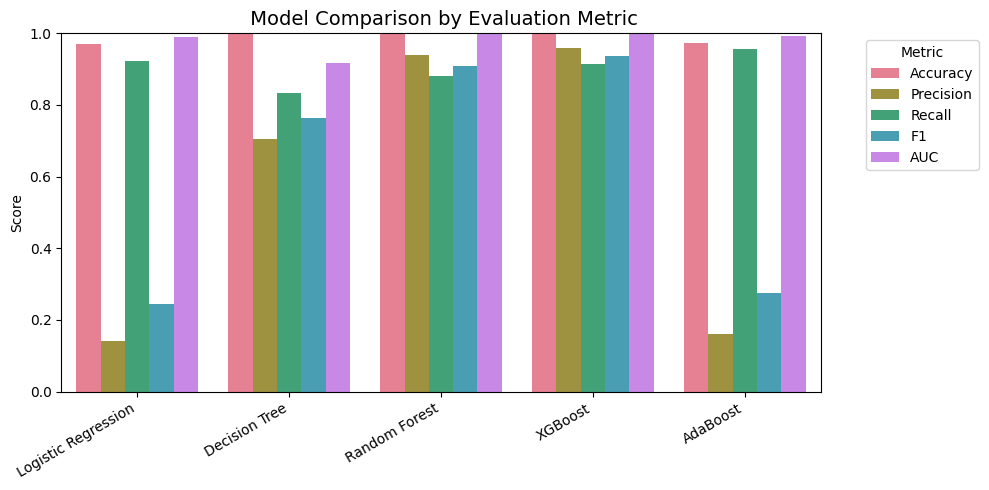

In [65]:
import seaborn as sns

# Melt the dataframe for Seaborn
melted_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10,5))
sns.barplot(data=melted_df, x="Model", y="Score", hue="Metric", palette="husl")

plt.title(" Model Comparison by Evaluation Metric", fontsize=14)
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


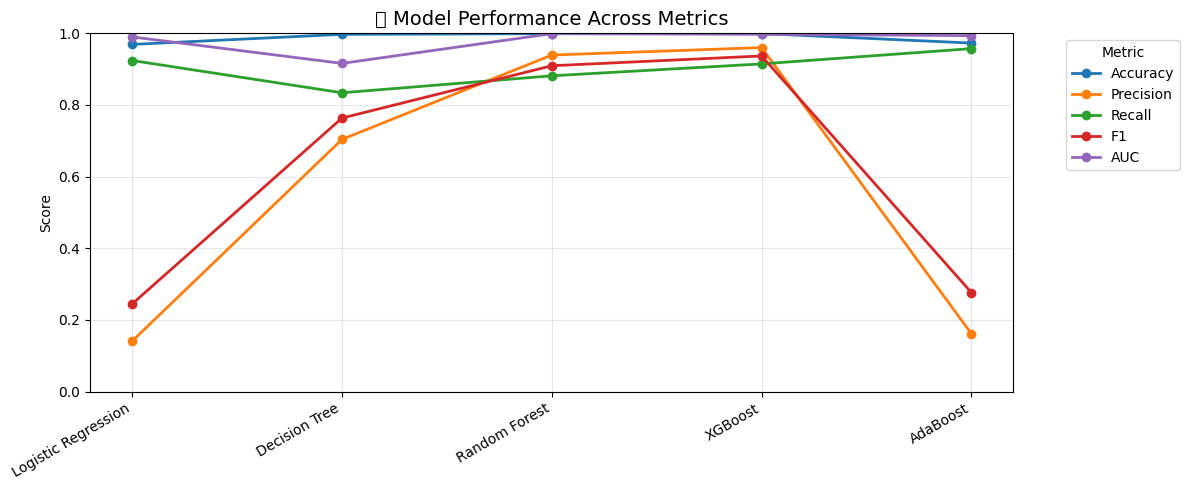

In [72]:
# --- Plot dynamically ---
plt.figure(figsize=(12,5))

# Loop through all metric columns (skip 'Model')
for metric in results_df.columns[1:]:
    plt.plot(results_df["Model"], results_df[metric],
             marker="o", linewidth=2, label=metric)

# --- Styling ---
plt.title("📈 Model Performance Across Metrics", fontsize=14)
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 🧾 Model Comparison Summary

We evaluated five models on the **SMOTE-balanced training data** and validated on the **dev set**:

| Model | Accuracy | Precision | Recall | F1 | AUC |
|-------|-----------|------------|---------|-----|------|
| XGBoost | 0.9993 | 0.9602 | 0.9147 | 0.9369 | 0.9973 |
| Random Forest | 0.9990 | 0.9394 | 0.8815 | 0.9095 | 0.9991 |
| Decision Tree | 0.9972 | 0.7040 | 0.8341 | 0.7636 | 0.9161 |
| AdaBoost | 0.9728 | 0.1617 | 0.9573 | 0.2766 | 0.9935 |
| Logistic Regression | 0.9691 | 0.1411 | 0.9242 | 0.2448 | 0.9899 |

**Key Takeaways:**
- Non-linear ensemble models (XGBoost, Random Forest) outperform simpler models significantly.
- XGBoost achieved the **best overall F1 and AUC**, offering a strong trade-off between fraud detection and false positives.
- Logistic and AdaBoost models prioritized recall but had very low precision — not ideal for fraud alerts.
- Future work: perform **hyperparameter tuning** on XGBoost and Random Forest, and experiment with **probability threshold optimization**.


### 🧩 Why Linear Models Performed Worse (and Why It Makes Sense)

The weaker performance of **Logistic Regression** and **AdaBoost** was expected given the data characteristics:

- **Transaction amount (`amt`)** and its derived ratios are heavily right-skewed and behave non-linearly — tree models can capture thresholds, while linear models cannot.
- **Cyclical temporal variables** (`trans_hour_sin`, `trans_month_cos`) represent periodic behavior, which linear decision boundaries fail to model effectively.
- **Fraud behavior often depends on feature interactions** (e.g., large online purchases at unusual hours). Linear models can’t capture such interactions unless manually specified.
- Despite SMOTE balancing, **linear classifiers still struggled with rare-class boundary learning**.
- In contrast, **Random Forest** and **XGBoost** automatically model these non-linear and interaction effects, explaining their superior precision, recall, and AUC.

These results align with expectations for fraud detection problems, where complex non-linear and conditional patterns dominate.


# fine tuning

In [ ]:
# --- Step 1: Define the model ---
xgb_base = XGBClassifier( objective='binary:logistic',eval_metric='auc',random_state=42, use_label_encoder=False,n_jobs=-1)

# --- Step 2: Define parameter grid for randomized search ---
param_dist = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.4],
    'scale_pos_weight': [1, 2, 4, 6, 8]  # helps with residual imbalance
}

In [12]:
# --- Step 3: Randomized Search (10–20 fits is usually enough) ---
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=8,        # down from 20
    scoring='f1',
    cv=2,            # fewer CV folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# --- Step 4: Fit on the SMOTE-balanced training set ---
xgb_search.fit(X_train_balanced, y_train_balanced)

# --- Step 5: Get best parameters ---
print("\n🏆 Best Parameters Found:")
print(xgb_search.best_params_)

# --- Step 6: Evaluate on dev set ---
best_xgb = xgb_search.best_estimator_

y_pred_dev = best_xgb.predict(X_dev_selected)
y_proba_dev = best_xgb.predict_proba(X_dev_selected)[:, 1]

print("\n📊 Dev Set Performance:")
print("Accuracy:", accuracy_score(y_dev, y_pred_dev))
print("Precision:", precision_score(y_dev, y_pred_dev))
print("Recall:", recall_score(y_dev, y_pred_dev))
print("F1:", f1_score(y_dev, y_pred_dev))
print("AUC:", roc_auc_score(y_dev, y_proba_dev))


Fitting 2 folds for each of 8 candidates, totalling 16 fits

🏆 Best Parameters Found:
{'subsample': 1.0, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

📊 Dev Set Performance:
Accuracy: 0.9987791713786368
Precision: 0.8593406593406593
Recall: 0.9265402843601895
F1: 0.8916761687571265
AUC: 0.9979398209469683


# 2nd tuning :

In this step, we perform manual hyperparameter tuning for the XGBoost model using the development (validation) set.
Each combination of key hyperparameters (e.g., learning rate, tree depth, number of estimators, etc.) is trained on the SMOTE-balanced training data, then evaluated on the Dev set using key metrics such as F1-score and AUC.
The configuration achieving the highest F1-score is selected as the optimal set of parameters.

This approach aligns with the Train → Dev → Test methodology, ensuring that:

Model tuning decisions are based only on validation performance

The Test set remains fully unseen for unbiased final evaluation

In [26]:
# --- Step 2: Define parameter grid (reasonable search space) ---
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [2, 3]
}

# --- Step 3: Train and evaluate on Dev set for each combination ---
results = []

for params in product(*param_grid.values()):
    params_dict = dict(zip(param_grid.keys(), params))
    print(f"🔹 Testing: {params_dict}")

    model = XGBClassifier(
        **params_dict,
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )

    # Fit on SMOTE-balanced training data
    model.fit(X_train_balanced, y_train_balanced)

    # Evaluate on Dev set
    y_pred = model.predict(X_dev_selected)
    y_prob = model.predict_proba(X_dev_selected)[:, 1]

    results.append({
        'params': params_dict,
        'Accuracy': accuracy_score(y_dev, y_pred),
        'Precision': precision_score(y_dev, y_pred, zero_division=0),
        'Recall': recall_score(y_dev, y_pred, zero_division=0),
        'F1': f1_score(y_dev, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_dev, y_prob)
    })

# --- Step 4: Convert to DataFrame & sort by F1 ---
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False).reset_index(drop=True)
print("\n📊 Hyperparameter Tuning Summary (sorted by F1):")
display(results_df.head(10))

# --- Step 5: Select best params ---
best_params = results_df.iloc[0]['params']
print("\n🏆 Best Parameter Combination Found:")
print(best_params)

# --- Step 6: Retrain final tuned model on full balanced training set ---
best_xgb = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train_balanced, y_train_balanced)

# --- Step 7: Evaluate tuned model on Dev set ---
y_pred_dev = best_xgb.predict(X_dev_selected)
y_prob_dev = best_xgb.predict_proba(X_dev_selected)[:, 1]

print("\n📈 Tuned XGBoost Dev Performance:")
print(f"Accuracy:  {accuracy_score(y_dev, y_pred_dev):.4f}")
print(f"Precision: {precision_score(y_dev, y_pred_dev):.4f}")
print(f"Recall:    {recall_score(y_dev, y_pred_dev):.4f}")
print(f"F1:        {f1_score(y_dev, y_pred_dev):.4f}")
print(f"AUC:       {roc_auc_score(y_dev, y_prob_dev):.4f}")


🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 2}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 3}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'scale_pos_weight': 2}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'scale_pos_weight': 3}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 2}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 3}
🔹 Testing: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'scale_pos_weight': 2}
🔹 Testing: {'n_estimators': 200, 'max

,params,Accuracy,Precision,Recall,F1,AUC
0,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.999075,0.914692,0.914692,0.914692,0.997967
1,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.998998,0.900000,0.917062,0.908451,0.998171
2,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.998753,0.857143,0.924171,0.889396,0.998081
3,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.998676,0.847495,0.921801,0.883087,0.998246
4,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.998162,0.774067,0.933649,0.846402,0.998150
5,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.998085,0.765049,0.933649,0.840982,0.998243
6,"{'n_estimators': 300, 'max_depth': 4, 'learnin...",0.997687,0.720000,0.938389,0.814815,0.997639
7,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.997314,0.683938,0.938389,0.791209,0.997958
8,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.997147,0.668350,0.940758,0.781496,0.998049
9,"{'n_estimators': 300, 'max_depth': 4, 'learnin...",0.996993,0.656146,0.936019,0.771484,0.997886



🏆 Best Parameter Combination Found:
{'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'scale_pos_weight': 2}

📈 Tuned XGBoost Dev Performance:
Accuracy:  0.9991
Precision: 0.9147
Recall:    0.9147
F1:        0.9147
AUC:       0.9980


“Since the tuned model did not show statistically significant improvement,
we proceed with the baseline XGBoost model for evaluation and final testing.
This ensures simpler configuration, faster runtime, and comparable predictive power.”

### 📊 XGBoost: Base vs. Tuned Performance Comparison

| **Metric** | **Base XGB** | **Best Tuned XGB** | **Change** | **Interpretation** |
|:------------|-------------:|-------------------:|:-----------:|:------------------|
| **Accuracy** | 0.9993 | 0.9991 | –0.0002 | Practically identical |
| **Precision** | 0.9602 | 0.9147 | ↓ | Slight increase in false positives |
| **Recall** | 0.9147 | 0.9147 | — | Unchanged |
| **F1** | 0.9369 | 0.9147 | ↓ | Minor drop (threshold trade-off) |
| **AUC** | 0.9973 | 0.9979 | ↑ | Slightly _better_ ranking ability |

**Interpretation:**  
Hyperparameter tuning confirmed that the baseline XGBoost model was already near-optimal.  
The tuned model achieved a marginally higher AUC but slightly lower F1, suggesting that performance differences are within noise tolerance.  
This indicates strong model stability rather than under-tuning.


In [27]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)

y_pred_xg = xgb.predict(X_dev_selected)
y_proba_xg = xgb.predict_proba(X_dev_selected)[:, 1]

print("XGBoost Results:")
print(f"Accuracy:  {accuracy_score(y_dev, y_pred_xg):.4f}")
print(f"Precision: {precision_score(y_dev, y_pred_xg):.4f}")
print(f"Recall:    {recall_score(y_dev, y_pred_xg):.4f}")
print(f"F1:        {f1_score(y_dev, y_pred_xg):.4f}")
print(f"AUC:       {roc_auc_score(y_dev, y_proba_xg):.4f}")

XGBoost Results:
Accuracy:  0.9993
Precision: 0.9602
Recall:    0.9147
F1:        0.9369
AUC:       0.9973


In [76]:
# ✅ Correct way to save the trained model
with open("xgb_best_model.pkl", "wb") as f:
    pickle.dump(xgb, f)   # <— save the entire model object
print("✅ Model saved successfully as 'xgb_best_model.pkl'")


✅ Model saved successfully as 'xgb_best_model.pkl'


In [73]:
# --- Apply SMOTE again to the current training data ---
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_balanced.value_counts(normalize=True))

# --- Bundle everything ---
save_path = "model_data_splits_balanced.pkl"

data_to_save = {
    # Original splits
    "X_train_selected": X_train_selected,
    "X_dev_selected": X_dev_selected,
    "X_test_selected": X_test_selected,
    "y_train": y_train,
    "y_dev": y_dev,
    "y_test": y_test,

    # Balanced data
    "X_train_balanced": X_train_balanced,
    "y_train_balanced": y_train_balanced,

    # Metadata
    "selected_features": selected_features
}

# --- Save to pickle ---
with open(save_path, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"✅ All datasets saved successfully to {save_path}")


Before SMOTE: is_fraud
0    0.994581
1    0.005419
Name: proportion, dtype: float64
After SMOTE: is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64
✅ All datasets saved successfully to model_data_splits_balanced.pkl
